# Evaluate integration accross species

In [2]:
import scanpy as sc
import pickle as pkl
import pandas as pd
import numpy as np
# Make random number for seed before scvi import sets seed to 0
seed=np.random.randint(0,1000000)
import argparse
import os
import string

from matplotlib.pyplot import rcParams
import matplotlib.pyplot as plt
import seaborn as sb

from cross_system_integration.model._xxjointmodel import XXJointModel
import pytorch_lightning as pl

# Otherwise the seed remains constant
from scvi._settings import ScviConfig
config=ScviConfig()
config.seed=seed

Global seed set to 0
Global seed set to 0
Global seed set to 732416


In [3]:
parser = argparse.ArgumentParser()
def intstr_to_bool(x):
    return bool(int(x))
def str_to_float_zeronone(x):
    if x is None or x=="0":
        return None
    else:
        return float(x)
def str_to_weight(x):
    # Quick seml fix to pass str and not int/list - add w at start and change sep
    x=[float(i) for i in x.replace('w','').split('_')]
    if len(x)==1:
        x=x[0]
    else:
        x={'weight_start':x[0], 'weight_end':x[1],
           'point_start':x[2], 'point_end':x[3], 
           'update_on':'step'}
    return x

parser.add_argument('-n', '--name', required=False, type=str, default=None,
                    help='name of replicate, if unspecified set to rSEED if seed is given '+\
                    'and else to blank string')
parser.add_argument('-s', '--seed', required=False, type=int, default=None,
                    help='random seed, if none it is randomly generated')
parser.add_argument('-loe', '--log_on_epoch', required=False, 
                    type=intstr_to_bool,default='1',
                    help='if true log on epoch and if false on step. Converts 0/1 to bool')
parser.add_argument('-po', '--params_opt', required=False, type=str, default='',
                    help='name of optimized params/test purpose')
parser.add_argument('-pa', '--path_adata', required=True, type=str,
                    help='full path to adata obj')
parser.add_argument('-ps', '--path_save', required=True, type=str,
                    help='directory path for saving, creates subdir within it')
parser.add_argument('-sk', '--system_key', required=True, type=str,
                    help='obs col with system info')
parser.add_argument('-gk', '--group_key', required=False, type=str,default=None,
                    help='obs col with group info')
parser.add_argument('-bk', '--batch_key', required=True, type=str,
                    help='obs col with batch info')
parser.add_argument('-ubk', '--use_batch_key', required=False, type=intstr_to_bool, default='1',
                    help='Whether to use batch key as batch in integration')
parser.add_argument('-ts', '--train_size', required=False, type=float,default=0.9,
                    help='train_size for training')
parser.add_argument('-ma', '--mixup_alpha', required=False, 
                    type=str_to_float_zeronone,default='0',
                    help='mixup_alpha for model. If unspecified or 0 dont use mixup_alpha, '+
                   'else use float for mixup_alpha')
parser.add_argument('-sd', '--system_decoders', required=False, 
                    type=intstr_to_bool,default='0',
                    help='system_decodersfor model. Converts 0/1 to bool')
parser.add_argument('-ovm', '--out_var_mode', required=False, type=str, default='feature',
                    help='out_var_mode')
parser.add_argument('-p', '--prior', required=False, type=str, default='standard_normal',
                    help='VAE prior')
parser.add_argument('-npc', '--n_prior_components', required=False, type=int, default=100,
                    help='n_prior_components used for vamp prior')
# N prior components system is int as system itself is 0/1
parser.add_argument('-pcs', '--prior_components_system', required=False, type=int, default=None,
                    help='system to sample prior components from for vamp prior.'+\
                   'If empty defaults to None and samples from both systems')
parser.add_argument('-zdm', '--z_dist_metric', required=False, type=str, default='MSE',
                    help='z_dist_metric for module')
parser.add_argument('-nl', '--n_layers', required=False, type=int, default=2,
                    help='n_layers of module')
parser.add_argument('-nh', '--n_hidden', required=False, type=int, default=256,
                    help='n_hidden of module')
parser.add_argument('-me', '--max_epochs', required=False, type=int,default=50,
                    help='max_epochs for training')
parser.add_argument('-edp', '--epochs_detail_plot', required=False, type=int, default=20,
                    help='Loss subplot from this epoch on')

parser.add_argument('-kw', '--kl_weight', required=False, 
                    type=str_to_weight,default=1,
                    help='kl_weight for training')
parser.add_argument('-kcw', '--kl_cycle_weight', required=False, 
                    type=str_to_weight,default=0,
                    help='kl_cycle_weight for training')
parser.add_argument('-rw', '--reconstruction_weight', required=False, 
                    type=str_to_weight,default=1,
                    help='reconstruction_weight for training')
parser.add_argument('-rmw', '--reconstruction_mixup_weight', required=False, 
                    type=str_to_weight,default=0,
                    help='kl_weight for training')
parser.add_argument('-rcw', '--reconstruction_cycle_weight', required=False, 
                    type=str_to_weight,default=0,
                    help='reconstruction_cycle_weight for training')
parser.add_argument('-zdcw', '--z_distance_cycle_weight', required=False, 
                    type=str_to_weight,default=0,
                    help='z_distance_cycle_weight for training')
parser.add_argument('-tcw', '--translation_corr_weight', required=False, 
                    type=str_to_weight,default=0,
                    help='translation_corr_weight for training')
parser.add_argument('-zcw', '--z_contrastive_weight', required=False, 
                    type=str_to_weight,default=0,
                    help='z_contrastive_weight for training')

parser.add_argument('-o', '--optimizer', required=False, type=str,default="Adam",
                    help='optimizer for training plan')
parser.add_argument('-lr', '--lr', required=False, type=float,default=0.001,
                    help='learning rate for training plan')
parser.add_argument('-rlrp', '--reduce_lr_on_plateau', required=False, 
                    type=intstr_to_bool, default="0",
                    help='reduce_lr_on_plateau for training plan')
parser.add_argument('-lrsm', '--lr_scheduler_metric', required=False, 
                    type=str, default='loss_train',
                    help='lr_scheduler_metric for training plan reduce_lr_on_plateau')
parser.add_argument('-lrp', '--lr_patience', required=False, type=int,default=5,
                    help='lr_patience for training plan reduce_lr_on_plateau')
parser.add_argument('-lrf', '--lr_factor', required=False, type=float,default=0.1,
                    help='lr_factor for training plan reduce_lr_on_plateau')
parser.add_argument('-lrm', '--lr_min', required=False, type=float,default=1e-7,
                    help='lr_min for training plan reduce_lr_on_plateau')
parser.add_argument('-lrtm', '--lr_threshold_mode', required=False, type=str,default='rel',
                    help='lr_threshold_mode for training plan reduce_lr_on_plateau')
parser.add_argument('-lrt', '--lr_threshold', required=False, type=float,default=0.1,
                    help='lr_threshold for training plan reduce_lr_on_plateau')

parser.add_argument('-swa', '--swa', required=False, 
                    type=intstr_to_bool, default="0", help='use SWA')
parser.add_argument('-swalr', '--swa_lr', required=False, type=float, default=0.001, 
                    help='final SWA lr')
parser.add_argument('-swaes', '--swa_epoch_start', required=False, type=int, default=10, 
                    help='start SWA on epoch')
parser.add_argument('-swaae', '--swa_annealing_epochs', required=False, type=int, 
                    default=10,  help='SWA annealing epochs')

parser.add_argument('-nce', '--n_cells_eval', required=False, type=int, default=-1,  
                    help='Max cells to be used for eval, if -1 use all cells. '+\
                   'For cell subsetting seed 0 is always used to be reproducible accros '+\
                   'runs with different seeds.')

parser.add_argument('-t', '--testing', required=False, type=intstr_to_bool,default='0',
                    help='Testing mode')

_StoreAction(option_strings=['-t', '--testing'], dest='testing', nargs=None, const=None, default='0', type=<function intstr_to_bool at 0x2ae807dc2e60>, choices=None, help='Testing mode', metavar=None)

In [4]:
if False:
    args= parser.parse_args(args=[
        '-pa','/om2/user/khrovati/data/cross_system_integration/brain_mmEmbryo_hsOrganoid/combined_orthologuesHVG.h5ad',
        '-ps','/om2/user/khrovati/data/cross_system_integration/brain_mmEmbryo_hsOrganoid/integration_runs/test/integration/',
        '-sk','system',
        '-bk','sample',
        '-me','2',
        '-edp','0',
        
        '-rw','1',
        
        '-s','1',
        
        # Lr testing
        '-o','AdamW',
        '-lr','0.001',
        '-rlrp','1',
        '-lrt','-0.05',
        # SWA testing
        '-swa','1',
        
        '-nce','1000',
        
        '-t','1'
    ])
# Read command line args
else:
    args = parser.parse_args()
    
print(args)

TESTING=args.testing

if args.name is None:
    if args.seed is not None:
        args.name='r'+str(args.seed)

Namespace(batch_key='sample', epochs_detail_plot=0, group_key=None, kl_cycle_weight=0, kl_weight=1, log_on_epoch=True, lr=0.001, lr_factor=0.1, lr_min=1e-07, lr_patience=5, lr_scheduler_metric='loss_train', lr_threshold=-0.05, lr_threshold_mode='rel', max_epochs=2, mixup_alpha=None, n_cells_eval=1000, n_hidden=256, n_layers=2, n_prior_components=100, name=None, optimizer='AdamW', out_var_mode='feature', params_opt='', path_adata='/om2/user/khrovati/data/cross_system_integration/brain_mmEmbryo_hsOrganoid/combined_orthologuesHVG.h5ad', path_save='/om2/user/khrovati/data/cross_system_integration/brain_mmEmbryo_hsOrganoid/integration_runs/test/integration/', prior='standard_normal', prior_components_system=None, reconstruction_cycle_weight=0, reconstruction_mixup_weight=0, reconstruction_weight=1.0, reduce_lr_on_plateau=True, seed=1, swa=True, swa_annealing_epochs=10, swa_epoch_start=10, swa_lr=0.001, system_decoders=False, system_key='system', testing=True, train_size=0.9, translation_cor

In [5]:
# Make folder for saving
def weight_to_str(x):
    if isinstance(x,dict):
        x='-'.join([str(x) for x in x.values() if not isinstance(x,str)])
    else:
        x=str(x)
    return x

path_save=args.path_save+\
    'UBK'+str(args.use_batch_key)+\
    'MA'+str(args.mixup_alpha)+\
    'SD'+str(args.system_decoders)+\
    'OVM'+str(args.out_var_mode)+\
    'KLW'+weight_to_str(args.kl_weight)+\
    'KLCW'+weight_to_str(args.kl_cycle_weight)+\
    'RW'+weight_to_str(args.reconstruction_weight)+\
    'RMW'+weight_to_str(args.reconstruction_mixup_weight)+\
    'RCW'+weight_to_str(args.reconstruction_cycle_weight)+\
    'ZDCW'+weight_to_str(args.z_distance_cycle_weight)+\
    'TCW'+weight_to_str(args.translation_corr_weight)+\
    'ZCW'+weight_to_str(args.z_contrastive_weight)+\
    'P'+str(''.join([i[0] for  i in args.prior.split('_')]))+\
    'NPC'+str(args.n_prior_components)+\
    'NL'+str(args.n_layers)+\
    'NH'+str(args.n_hidden)+\
    '_'+''.join(np.random.permutation(list(string.ascii_letters)+list(string.digits))[:8])+\
    ('-TEST' if TESTING else '')+\
    os.sep

os.mkdir(path_save)
print(path_save)

/om2/user/khrovati/data/cross_system_integration/brain_mmEmbryo_hsOrganoid/integration_runs/test/integration/MANoneSDFalseOVMfeatureKLW1KLCW0RW1.0RMW0RCW0ZDCW0TCW0ZCW0PsnNPC100NL2NH256_op7TJ2NY-TEST/


In [6]:
# Set seed for eval
# Set only here below as need randomness for generation of out directory name (above)
if args.seed is not None:
    config.seed=args.seed

Global seed set to 1


In [7]:
# Save args
pkl.dump(args,open(path_save+'args.pkl','wb'))

## Integration

### Prepare data

In [8]:
# Load data
adata=sc.read(args.path_adata)

In [9]:
if TESTING:
    # Make data smaller if testing the script
    random_idx=np.random.permutation(adata.obs_names)[:5000]
    adata=adata[random_idx,:].copy()
    print(adata.shape)
    # Set some groups to nan for testing if this works
    #adata.obs[args.group_key]=[np.nan]*10+list(adata.obs[args.group_key].iloc[10:])

(5000, 1347)


### Training

In [10]:
print('Train')

Train


In [11]:
# Setup adata
adata_training = XXJointModel.setup_anndata(
    adata=adata,
    system_key=args.system_key,
    group_key=args.group_key,
    categorical_covariate_keys=[args.batch_key] if args.use_batch_key else None,
)

INFO     Using column names from columns of adata.obsm['covariates']                                               
INFO     Using column names from columns of adata.obsm['system']                                                   


In [12]:
# Train
if args.prior_components_system is not None:
    pdi=np.random.permutation(np.argwhere((
            adata_training.obs[args.system_key]==args.prior_components_system
                    ).ravel()).ravel())[:args.n_prior_components]
else:
    pdi=None
model = XXJointModel(
    adata=adata_training,
    out_var_mode=args.out_var_mode,
    mixup_alpha=args.mixup_alpha,
    system_decoders=args.system_decoders,
    prior=args.prior, 
    n_prior_components=args.n_prior_components,
    pseudoinputs_data_indices=pdi,
    z_dist_metric = args.z_dist_metric,
    n_layers=args.n_layers,
    n_hidden=args.n_hidden,
)
max_epochs=args.max_epochs if not TESTING else 3
model.train(max_epochs=max_epochs,
            log_every_n_steps=1,
            check_val_every_n_epoch=1,
            val_check_interval=1.0 if args.log_on_epoch else 1,
            train_size=args.train_size,            
            callbacks=[pl.callbacks.LearningRateMonitor(logging_interval='epoch')] +\
                [pl.callbacks.StochasticWeightAveraging(
                    swa_lrs=args.swa_lr, 
                    swa_epoch_start=args.swa_epoch_start, 
                    annealing_epochs=args.swa_annealing_epochs)] 
                if args.swa else [],
            plan_kwargs={
                'optimizer':args.optimizer,
                'lr':args.lr,
                'reduce_lr_on_plateau':args.reduce_lr_on_plateau,
                'lr_scheduler_metric':args.lr_scheduler_metric,
                'lr_patience':args.lr_patience,
                'lr_factor':args.lr_factor,
                'lr_min':args.lr_min,
                'lr_threshold_mode':args.lr_threshold_mode,
                'lr_threshold':args.lr_threshold,
                'log_on_epoch':args.log_on_epoch,
                'log_on_step':not args.log_on_epoch,
                'loss_weights':{
                   'kl_weight':args.kl_weight,
                   'kl_cycle_weight':args.kl_cycle_weight,
                   'reconstruction_weight':args.reconstruction_weight,
                   'reconstruction_mixup_weight':args.reconstruction_mixup_weight,
                   'reconstruction_cycle_weight':args.reconstruction_cycle_weight,
                   'z_distance_cycle_weight':args.z_distance_cycle_weight,
                   'translation_corr_weight':args.translation_corr_weight,
                   'z_contrastive_weight':args.z_contrastive_weight,
               
           }})

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


Epoch 1/4:   0%|          | 0/4 [00:00<?, ?it/s]

/om2/user/khrovati/miniconda/envs/torch2/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:231: UserWarning: You called `self.log('z_contrastive_train', ...)` in your `training_step` but the value needs to be floating point. Converting it to torch.float32.
  f"You called `self.log({self.meta.name!r}, ...)` in your `{self.meta.fx}` but the value needs to"
/om2/user/khrovati/miniconda/envs/torch2/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:231: UserWarning: You called `self.log('z_contrastive_pos_train', ...)` in your `training_step` but the value needs to be floating point. Converting it to torch.float32.
  f"You called `self.log({self.meta.name!r}, ...)` in your `{self.meta.fx}` but the value needs to"
/om2/user/khrovati/miniconda/envs/torch2/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:231: UserWarning: You called `self.log('z_contrastive_neg_train',

Epoch 2/4:  25%|██▌       | 1/4 [00:02<00:08,  2.82s/it, loss=203, v_num=1]

/om2/user/khrovati/miniconda/envs/torch2/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:231: UserWarning: You called `self.log('z_contrastive_validation', ...)` in your `validation_step` but the value needs to be floating point. Converting it to torch.float32.
  f"You called `self.log({self.meta.name!r}, ...)` in your `{self.meta.fx}` but the value needs to"
/om2/user/khrovati/miniconda/envs/torch2/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:231: UserWarning: You called `self.log('z_contrastive_pos_validation', ...)` in your `validation_step` but the value needs to be floating point. Converting it to torch.float32.
  f"You called `self.log({self.meta.name!r}, ...)` in your `{self.meta.fx}` but the value needs to"
/om2/user/khrovati/miniconda/envs/torch2/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:231: UserWarning: You called `self.log('z_contrasti

Epoch 4/4: 100%|██████████| 4/4 [00:10<00:00,  2.64s/it, loss=381, v_num=1]


### Eval

#### Losses

In [13]:
print('Plot losses')

Plot losses


In [14]:
# Save losses
pkl.dump(model.trainer.logger.history,open(path_save+'losses.pkl','wb'))

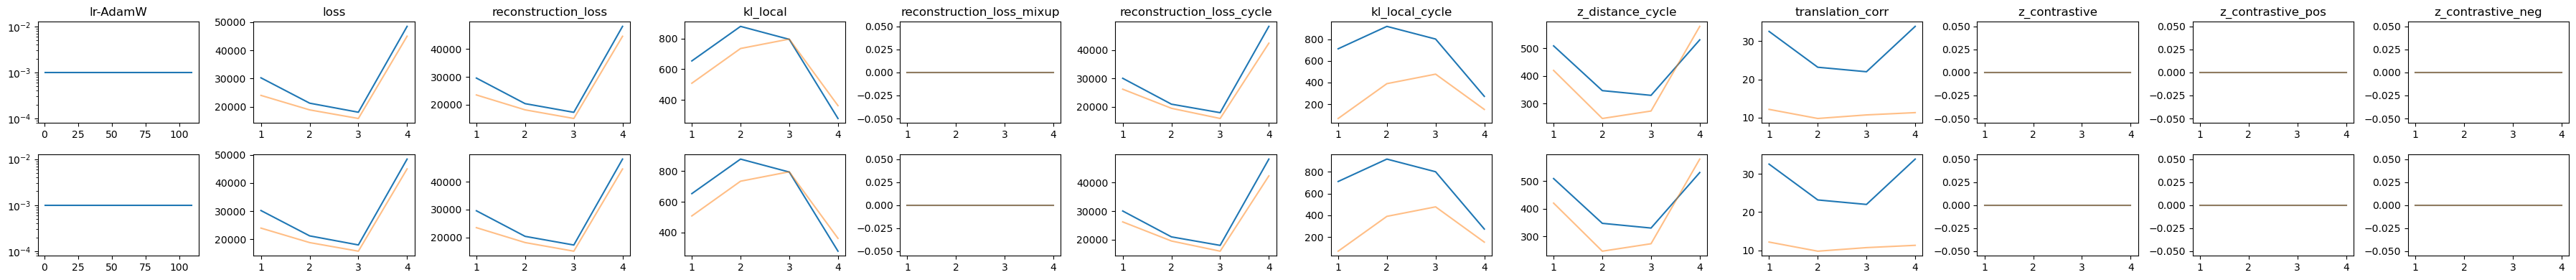

In [15]:
# Plot all loses
steps_detail_plot = args.epochs_detail_plot*int(
    model.trainer.logger.history['loss_validation'].shape[0]/max_epochs)
detail_plot=args.epochs_detail_plot if args.log_on_epoch else steps_detail_plot
losses=[k for k in model.trainer.logger.history.keys() 
        if #'_step' not in k and '_epoch' not in k and 
        ('validation' not in k or 'eval' in k)]
fig,axs=plt.subplots(2,len(losses),figsize=(len(losses)*3,4))
for ax_i,l_train in enumerate(losses):
    if 'lr-' not in l_train and '_eval' not in l_train:
        l_val=l_train.replace('_train','_validation')
        l_name=l_train.replace('_train','')
        # Change idx of epochs to start with 1 so that below adjustment when 
        # train on step which only works for wal leads to appropriate multiplication
        l_val_values=model.trainer.logger.history[l_val].copy()
        l_val_values.index=l_val_values.index+1
        l_train_values=model.trainer.logger.history[l_train].copy()
        l_train_values.index=l_train_values.index+1
        # This happens if log on step as currently tyhis works only for val loss
        if l_train_values.shape[0]<l_val_values.shape[0]:
            l_train_values.index=\
                l_train_values.index*int(l_val_values.shape[0]/l_train_values.shape[0])
        for l_values,c,alpha,dp in [
            # train loss logged on epoch in either case now
            (l_train_values,'tab:blue',1,args.epochs_detail_plot),
            (l_val_values,'tab:orange',0.5, detail_plot)]:
            axs[0,ax_i].plot( l_values.index,l_values.values.ravel(),c=c,alpha=alpha)
            axs[0,ax_i].set_title(l_name)
            axs[1,ax_i].plot(l_values.index[dp:],
                             l_values.values.ravel()[dp:],c=c,alpha=alpha)
    else:
        l_values=model.trainer.logger.history[l_train].copy()
        l_values.index=l_values.index+1
        axs[0,ax_i].plot(l_values.index,l_values.values.ravel())
        axs[0,ax_i].set_title(l_train.replace('_validation_eval',''))
        # Lr has index of steps but logged number of epochs
        dp= args.epochs_detail_plot if 'lr-' in l_train else detail_plot
        axs[1,ax_i].plot(l_values.index[dp:],l_values.values.ravel()[dp:])
        if 'lr' in l_train:
            axs[0,ax_i].set_yscale('log')
            axs[1,ax_i].set_yscale('log')
fig.tight_layout()
plt.savefig(path_save+'losses.png',dpi=300,bbox_inches='tight')

#### Embedding

In [16]:
print('Plot embedding')

Plot embedding


In [17]:
# Compute embedding
cells_eval=adata_training.obs_names if args.n_cells_eval==-1 else \
    np.random.RandomState(seed=0).permutation(adata_training.obs_names)[:args.n_cells_eval]
print('N cells for eval:',cells_eval.shape[0])
embed = model.embed(
        adata=adata_training[cells_eval,:],
        indices=None,
        batch_size=None,
        as_numpy=True)

embed=sc.AnnData(embed,obs=adata_training[cells_eval,:].obs)

N cells for eval: 1000
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [18]:
# Use 90 neighbours so that this can be also used for lisi metrics
sc.pp.neighbors(embed, use_rep='X', n_neighbors=90)
sc.tl.umap(embed)

In [19]:
# Make system categorical, also for metrics below
embed.obs[args.system_key]=embed.obs[args.system_key].astype(str)

In [20]:
# Save embed
embed.write(path_save+'embed.h5ad')

/om2/user/khrovati/miniconda/envs/torch2/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


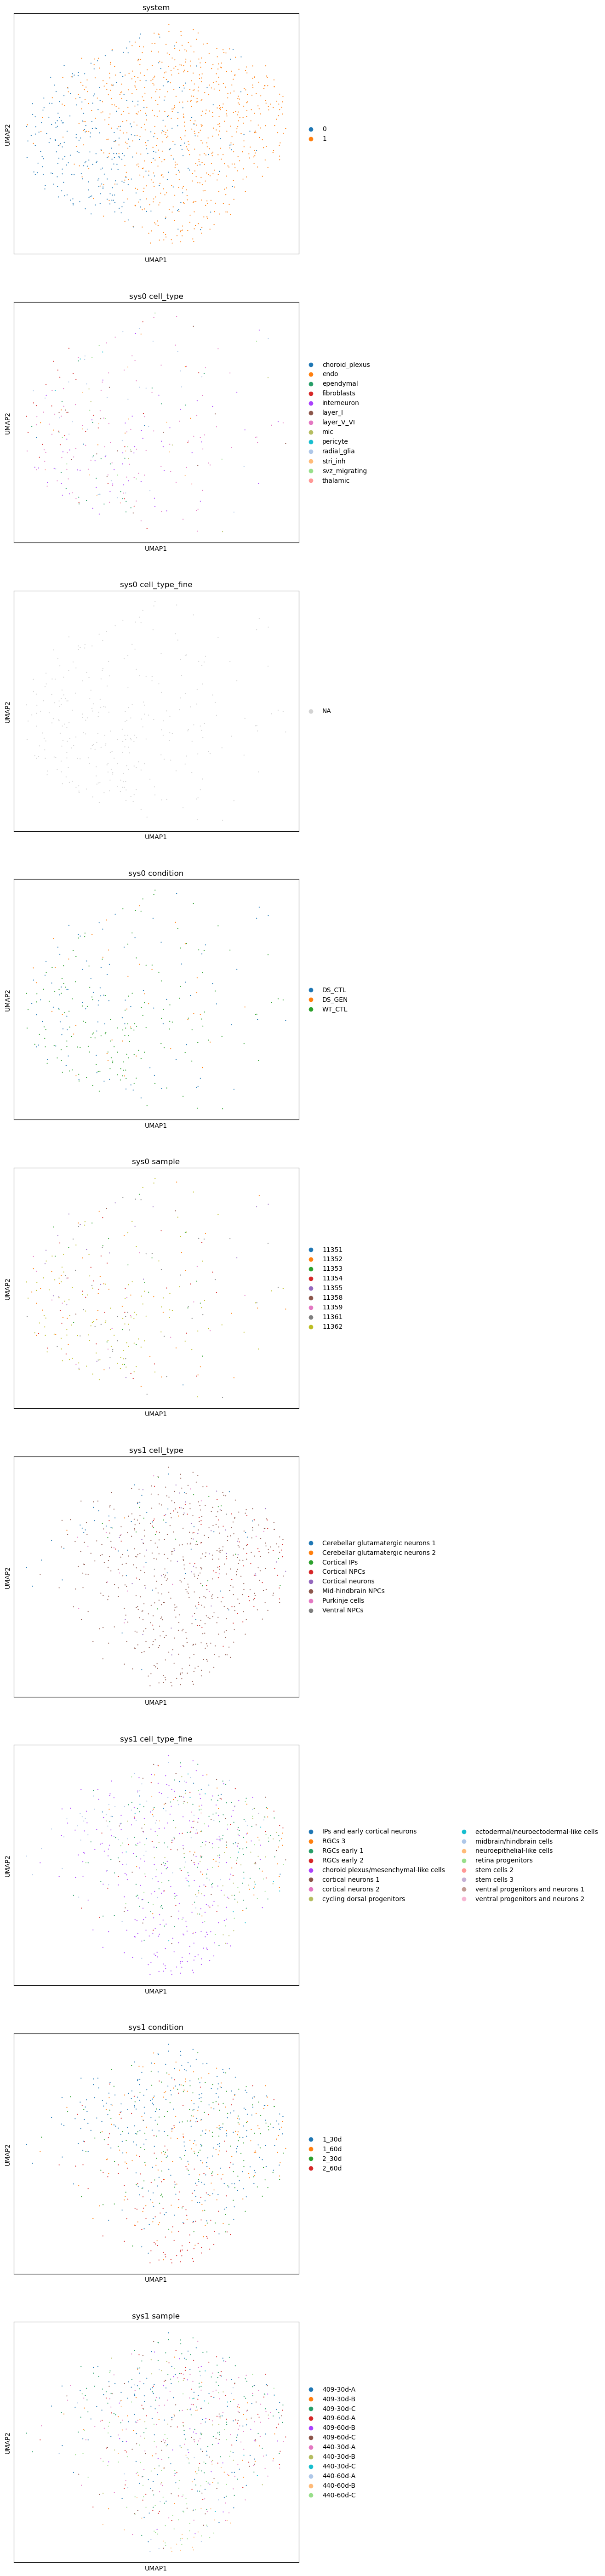

In [21]:
# Plot embedding
rcParams['figure.figsize']=(8,8)
cols=[args.system_key]
cols_system=sorted([c for c in adata.obs.columns if c !=args.system_key])
n_rows=len(cols)+2*len(cols_system)
fig,axs=plt.subplots(n_rows,1,figsize=(8,8*n_rows))
for col,ax in zip(cols,axs[:len(cols)]):
    idxs=np.random.permutation(embed.obs_names)
    sc.pl.umap(embed[idxs,:],color=col,s=10,ax=ax,show=False,sort_order=False)
for col,ax in zip(cols_system,axs[len(cols):len(cols_system)+len(cols)]):
    idxs=np.random.permutation(embed[embed.obs[args.system_key]=='0',:].obs_names)
    sc.pl.umap(embed[idxs,:],
               color=col,s=10,ax=ax,show=False,sort_order=False,title='sys0 '+str(col)) 
for col,ax in zip(cols_system,axs[len(cols)+len(cols_system):]):
    idxs=np.random.permutation(embed[embed.obs[args.system_key]=='1',:].obs_names)
    sc.pl.umap(embed[idxs,:],
               color=col,s=10,ax=ax,show=False,sort_order=False,title='sys1 '+str(col))  
plt.savefig(path_save+'umap.png',dpi=300,bbox_inches='tight')

# End

In [22]:
print('Finished!')

Finished!
